# Dataset Prepping

## Downloading data from NORAINPLUS github repo

In [1]:
import pathlib

from google.colab import files

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt


# clone git if doesn't exist
if not pathlib.Path("NORAINPLS").exists():
    !git clone https://github.com/jupiterbjy/NORAINPLS.git

%cd NORAINPLS


# load dataset
from data import dataset

Cloning into 'NORAINPLS'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 70 (delta 21), reused 60 (delta 16), pack-reused 0
Unpacking objects: 100% (70/70), 2.48 MiB | 2.22 MiB/s, done.
/content/NORAINPLS
- Loading 2012.csv
- Loading 2013.csv
- Loading 2014.csv
- Loading 2015.csv
- Loading 2016.csv
- Loading 2017.csv
- Loading 2018.csv
- Loading 2019.csv
- Loading 2020.csv
- Loading 2021.csv
- Loading 2022.csv
Fetched 11 datasets


## Checking data

In [2]:
# show sample data
sample_x, sample_y = dataset[0]

print(sample_x.shape)
print(sample_x, end="\n\n")

print(sample_y.shape)
print(sample_y)

(8758, 8)
[[ -0.1   1.3  73.  ...   0.    0.   -1.2]
 [ -0.5   0.8  74.  ...   7.    7.   -1.7]
 [ -1.2   1.5  77.  ...   6.    6.   -2.7]
 ...
 [ -9.8   1.9  53.  ...   0.    0.   -2.4]
 [-10.3   1.1  54.  ...   0.    0.   -2.6]
 [-10.7   1.1  54.  ...   0.    0.   -2.8]]

(8758, 1)
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


## Align Data & Convert Continuous Y into Binary form

In [3]:
# Combine yearly data as one giant list & split some out as test data
x_test, y_test = dataset[-1]

x_train = np.concatenate(dataset.xs[:-1])
y_train = np.concatenate(dataset.ys[:-1])


# We want to predict amount of rain 1 hour later, not immediate.
# in that sense, data is off by 1. We need to remove last X & first Y
x_train = x_train[:-1]
y_train = y_train[1:]

x_test = x_test[:-1]
y_test = y_test[1:]


# Make new Y as rain chance. 0 being 0% rain, 1 being 100% rain chance
y_train = [1 if rain != 0 else 0 for rain in y_train]
y_test = [1 if rain != 0 else 0 for rain in y_test]

y_train = np.array(y_train)
y_test = np.array(y_test)


# Print out
print("X train shape:", x_train.shape)
print("Y train shape:", y_train.shape)
print("X test shape:", x_test.shape)
print("Y test shape:", y_test.shape)

X train shape: (87420, 8)
Y train shape: (87420,)
X test shape: (8734, 8)
Y test shape: (8734,)


## Assert adjusted dataset is in-line with original dataset

In [4]:
# Assert that dataset is correct by counting number of non-zero values.
# Excluding cut-off first Y that doesn't have matching X, should be similar

# sum each year's data
original = sum(np.count_nonzero(y) for y in dataset.ys[:-1])
print("Original continuous data's rain count:", original)

# show
print("Binary discrete data's rain count:", np.count_nonzero(y_train))

Original continuous data's rain count: 4891
Binary discrete data's rain count: 4891


## Hard-code 2032's data as real-life prediction test

In [5]:
# Actual data from 2023, where it rained - will be used to inference one by one
# all 5 data is from rained day's.

predict_x = np.array([
    [8, 4.8, 100, 1000.2, 1010.6, 10, 8, 3.6],
    [14.4, 2.3, 100, 996.6, 1006.7, 10, 8, 14.5],
    [7.8, 2.6, 93, 1007.4, 1017.9, 10, 9, 7.7],
    [11.5, 1.9, 86, 1004.1, 1014.4, 6, 6, 8.4],
    [5.7, 3.4, 86, 1005.9, 1016.5, 10, 9, 1.8],
    [1.6, 1.6, 74, 1018.1, 1029, 8, 8, -1.8],
    [-2.7, 2.5, 49, 1019.8, 1030.9, 0, 0, -1.9],
    [12.5, 3.6, 47, 1001.2, 1011.4, 10, 10, 10.4],
    [21.9, 3.8, 43, 1004.8, 1014.7, 10, 3, 23.6],
])
predict_x[:, 3] -= 1000
predict_x[:, 4] -= 1000


predict_x_dates = [
    "2023-01-13  09:00",
    "2023-04-05  13:00",
    "2023-03-12  09:00",
    "2023-03-09  03:00",
    "2023-01-13  03:00",
    "2023-01-01  04:00",
    "2023-02-20  23:00",
    "2023-05-07  05:00",
    "2023-05-25  20:00",
]

# Not used, but keeping how much it actually rained as reference
predict_y = np.array([18.3, 7.8, 1.4, 3.6, 10.8, 0, 0, 0, 0])

---

# Model & Training

## Training function

In [15]:
# Universal training function & Real Life Confidence level
# since this is binary activation output, using single sigmoid output
# and binary cross entropy

def train(model_, epoch, train_x, train_y, test_x, test_y):

    model_.compile(
        optimizer="adam",
        # loss="sparse_categorical_crossentropy",
        loss="binary_crossentropy",
        metrics = ["accuracy"]
    )
    
    print("\nTraining Start")
    hist = model_.fit(train_x, train_y, epochs=epoch, validation_data=(test_x, test_y))

    print("\nSample")
    show_confidence(model_)

    print("\nGraphs")
    show_graph(hist)

## Graphing Function

In [7]:
def show_graph(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    
    plt.title("Training result")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")

    plt.legend(["Training", "Validation"], loc="lower right")

## Confidence result function (Tests with 2023 data)

In [8]:
# Show Confidence on actual data

def show_confidence(model_):   
    for data, date, rain_amount in zip(predict_x, predict_x_dates, predict_y):

        # input must be [batch, features], so expand dim
        confidence = model_dnn.predict(np.expand_dims(data, axis=0), verbose=0)
        confidence = confidence[0][0] * 100
        
        print(f" {date} - Confidence: {confidence:.4f}% - Actual: {rain_amount}mm")

## Simple 4-Layer DNN Training & Evaluating

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 8)                 72        
                                                                 
 dense_21 (Dense)            (None, 4)                 36        
                                                                 
 dense_22 (Dense)            (None, 2)                 10        
                                                                 
 dense_23 (Dense)            (None, 1)                 3         
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________

Training Start
Epoch 1/4
2732/2732 [==============================] - 13s 4ms/step - loss: 0.4493 - accuracy: 0.9435 - val_loss: 0.2555 - val_accuracy: 0.9397
Epoch 2/4
2732/2732 [=======

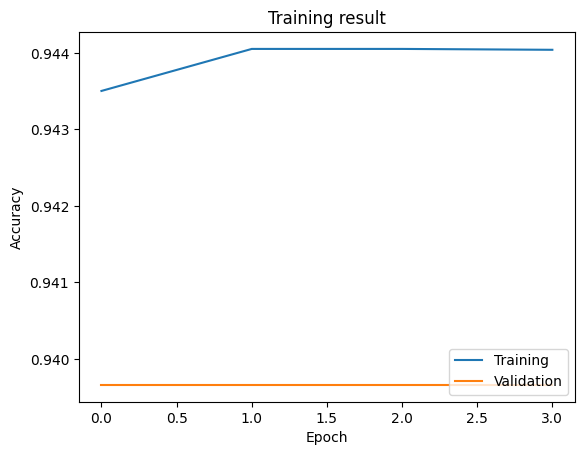

In [13]:
# Trying simple DNN

model_dnn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(2, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])


train(model_dnn, 4, x_train, y_train, x_test, y_test)


Training Start
Epoch 1/4
1/1 [==============================] - 298s 298s/step - loss: 2.0355 - accuracy: 0.0627 - val_loss: 5.9399 - val_accuracy: 0.1283
Epoch 2/4
1/1 [==============================] - 313s 313s/step - loss: 1.9819 - accuracy: 0.0640 - val_loss: 5.7964 - val_accuracy: 0.1305
Epoch 3/4
1/1 [==============================] - 291s 291s/step - loss: 1.9300 - accuracy: 0.0656 - val_loss: 5.6559 - val_accuracy: 0.1328
Epoch 4/4
1/1 [==============================] - 289s 289s/step - loss: 1.8799 - accuracy: 0.0670 - val_loss: 5.5186 - val_accuracy: 0.1346

Sample
 2023-01-13  09:00 - Confidence: 5.5693% - Actual: 18.3mm
 2023-04-05  13:00 - Confidence: 5.5693% - Actual: 7.8mm
 2023-03-12  09:00 - Confidence: 5.5693% - Actual: 1.4mm
 2023-03-09  03:00 - Confidence: 5.5693% - Actual: 3.6mm
 2023-01-13  03:00 - Confidence: 5.5693% - Actual: 10.8mm
 2023-01-01  04:00 - Confidence: 5.5693% - Actual: 0.0mm
 2023-02-20  23:00 - Confidence: 5.5693% - Actual: 0.0mm
 2023-05-07  05

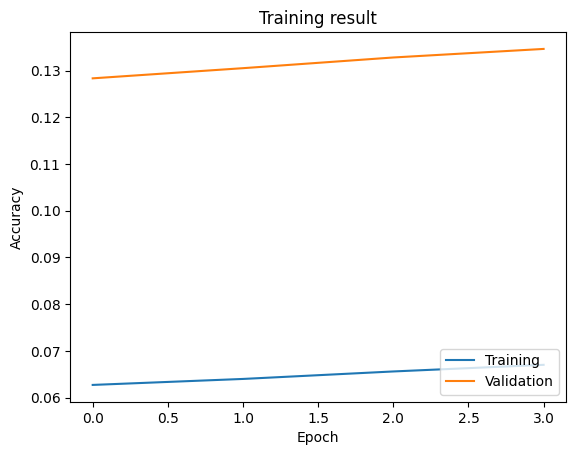

In [16]:
# Trying simple RNN
# since this is binary activation output, using single sigmoid output
# and binary cross entropy

model_rnn = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(8, activation="relu", return_sequences=True),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(2, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

train(model_rnn, 4, x_train[np.newaxis, :], y_train[np.newaxis, :], x_test[np.newaxis, :], y_test[np.newaxis, :])